In [8]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdRGroupDecomposition as rdRGD
# 显示图片

import py3Dmol
def drawit(m,p=None,confId=-1):
        mb = Chem.MolToMolBlock(m,confId=confId)
        if p is None:
            p = py3Dmol.view(width=400,height=400)
        p.removeAllModels()
        p.addModel(mb,'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber',str(idx))
    return mol

In [9]:
def pdb_2_lig_block(pdb_path,lig_id,smiles):
    # 抽取pdbfile中的ligand部分
    # rdkit可读字符串形式的pdbBlock
    num = Chem.MolFromSmiles(smiles).GetNumAtoms()
    ligand_lines = []
    with open(pdb_path) as ent:
        for line in ent:
            if line[0:6] == "HETATM" and line[17:20] == lig_id:
                ligand_lines.append(line)
    ligand_start = 0
    ligand_end = len(ligand_lines)
    for i in range(1,len(ligand_lines)):
        if ligand_lines[i][17:26] != ligand_lines[i-1][17:26]:
            ligand_end = i
            if ligand_end - ligand_start >= num:
                break
            else:
                ligand_start = i
                ligand_end = len(ligand_lines)
        else:
            pass
    if ligand_end - ligand_start < 2*num:
        lig_Block="".join(ligand_lines[ligand_start:ligand_end])
    else:
        lig_Block="".join(ligand_lines[ligand_start:ligand_start+num])
    return lig_Block
key='16K'
pdb_id='4ek8'
lig_smi="Cc1c(sc(n1)C)c2ccnc(n2)Nc3cccc(c3)[N+](=O)[O-]"
pdb_path = f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/lig_in_pdb/pdb_dataset/pdb/pdb{pdb_id}.ent"
lig_block = pdb_2_lig_block(pdb_path,key,lig_smi)
drawit(Chem.MolFromPDBBlock(lig_block))
drawit(Chem.MolFromSmiles(lig_smi))


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [10]:
def get_connect_atom_in_core(orimol,sidechain_atom_idxes):
    # mol is the whole molecule, the sidechain_atom_idx is the a tuple of the atom idx of a sidechain;
    # this function will get the atom connected with the .
    connect_atoms_in_core = []
    for idx in sidechain_atom_idxes:
        for atom in orimol.GetAtomWithIdx(idx).GetNeighbors():
            if atom.GetIdx() not in sidechain_atom_idxes:
                connect_atoms_in_core.append(atom.GetIdx())
    return connect_atoms_in_core

In [11]:
def get_connect_atom_in_sidechain(orimol,core):
    rings = orimol.GetRingInfo()
    for r in rings.AtomRings():
        count = 0
        for idx in core:
            if idx in set(r):
                count += 1
        if count == len(core) - 2:
            core_atom_idx = set(r)
            connect_atom_in_sidechain = set(core) - core_atom_idx
    return list(connect_atom_in_sidechain)


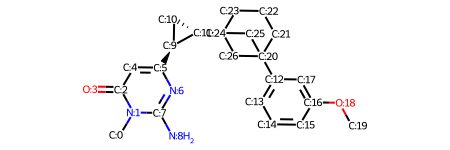

In [12]:
def phe2bch_test(smi):
    # 用于将给定配体中的*间位苯环骨架*替换为*螺旋桨烷骨架*的脚本
    # 用smi指定ligand的结构

    # 读入分子
    mol = Chem.MolFromSmiles(smi)
    # 识别间位取代部分: * 匹配任意原子；'!:' 非芳香键； *!:ccc(!:*)ccc 含间位取代的苯环
    patt = Chem.MolFromSmarts("*!:ccc(!:*)ccc")
    match = mol.GetSubstructMatches(patt)
    
    # 识别两个间位取代基与苯环的连接原子
    connect_atoms = get_connect_atom_in_sidechain(mol,match[0])
    # 识别需要被替换苯环原子
    core = set(match[0])-set(connect_atoms)

    # 记录第一部分的原子数目
    mol1_Atom_num = mol.GetNumAtoms()

    # 引入螺旋桨烷，并将其与原分子置于一处，使得其编号从·mol1_Atom_num+0·开始
    re_pat = Chem.MolFromSmiles("C12CCCC(C2)C1")
    mid_mol = Chem.CombineMols(mol,re_pat)
    mid_edited = Chem.EditableMol(mid_mol)

    # 开始成键,螺旋桨烷烃的桥头碳分别为mol1_Atom_num和mol1_Atom_num+4
    mid_edited.AddBond(connect_atoms[0],mol1_Atom_num,order=Chem.rdchem.BondType.SINGLE)
    mid_edited.AddBond(connect_atoms[1],mol1_Atom_num+4,order=Chem.rdchem.BondType.SINGLE)
    # 删除原来的苯环,每删除一个原子后原子序号都会发生改变，所以需要倒序删除。
    phenyl_atoms = list(core)
    phenyl_atoms.sort(reverse=True)
    for i in phenyl_atoms:
        mid_edited.RemoveAtom(i)
    BCHep_mol = mid_edited.GetMol()
    return BCHep_mol

test = phe2bch_test("CN1C(=O)C=C(N=C1N)[C@H]2C[C@H]2c3cccc(c3)c4cccc(c4)OC")
mol_with_atom_index(test)

In [13]:
def copy_partconf(refmol,refconf,partsmi,inpmol,inpconf,inpff):
    # introduct a middle mol for 
    partmol = Chem.MolFromSmarts(partsmi)
    partmol = Chem.AddHs(partmol)
    AllChem.EmbedMolecule(partmol)
    partmol = Chem.RemoveAllHs(partmol)
    partconf = partmol.GetConformer()

    # copy conf from refmol to middle mol
    mcs_ref2part = rdFMCS.FindMCS([refmol, partmol],timeout=3)
    for i, j in zip(refmol.GetSubstructMatch(mcs_ref2part),partmol.GetSubstructMatch(mcs_ref2part)):
        partconf.SetAtomPosition(j,refconf.GetAtomPosition(i))
    mcs_part2inp = rdFMCS.FindMCS([inpmol, partmol],timeout=3)
    
    # copy conf from middle mol to inpmol
    for i, j in zip(partmol.GetSubstructMatch(mcs_part2inp),inpmol.GetSubstructMatch(mcs_part2inp)):
        inpff.AddFixedPoint(j)
        inpconf.SetAtomPosition(j,partconf.GetAtomPosition(i))
    return 0



In [14]:
def getpdb_test(refmol,inpmol,pdbfile):
    
    bonded_conf = refmol.GetConformer()
    conf_res = inpmol.GetConformer()
    inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol)
    if inpmol_prop:
        ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol,inpmol_prop)
    else:
        ff_mcs = Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(inpmol)


    core = Chem.MolFromSmiles("C12CCCC(C2)C1")
    side_chains, unmatched = rdRGD.RGroupDecompose([core],[inpmol])
    for R in ['R1','R2']:
        sidechain = side_chains[0][R]
        sidechain_conf = sidechain.GetConformer()

        mcs_ref2mid = rdFMCS.FindMCS([refmol, sidechain],timeout=3,bondCompare=rdFMCS.BondCompare.CompareAny)
        for i, j in zip(refmol.GetSubstructMatch(mcs_ref2mid.queryMol),sidechain.GetSubstructMatch(mcs_ref2mid.queryMol)):
            sidechain_conf.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))
        
        mcs_mid2inp = rdFMCS.FindMCS([inpmol, sidechain],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
        for i, j in zip(sidechain.GetSubstructMatch(mcs_mid2inp.queryMol),inpmol.GetSubstructMatch(mcs_mid2inp.queryMol)):
            try:
                ff_mcs.AddFixedPoint(j)
                conf_res.SetAtomPosition(j, sidechain_conf.GetAtomPosition(i))
            except:
                print(f"error {inpmol.GetAtomWithIdx(j).GetSymbol()}")
        
        mcs1 = rdFMCS.FindMCS([refmol, sidechain],timeout=3,bondCompare=rdFMCS.BondCompare.CompareAny)
        mcs3 = rdFMCS.FindMCS([inpmol, sidechain],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
        sidechain_ref = refmol.GetSubstructMatch(mcs1.queryMol)
        sidechain_gen = inpmol.GetSubstructMatch(mcs3.queryMol)
        atom_connect_sidechain_core_ref = get_connect_atom_in_core(refmol, sidechain_ref)[0]
        atom_connect_sidechain_core_gen = get_connect_atom_in_core(inpmol, sidechain_gen)[0]
        ff_mcs.AddFixedPoint(atom_connect_sidechain_core_gen)
        conf_res.SetAtomPosition(atom_connect_sidechain_core_gen,bonded_conf.GetAtomPosition(atom_connect_sidechain_core_ref))
        
    for i in range(6):
        try:
            ff_mcs.Minimize()
        except:
            pass

#    for i, j in zip(refmol.GetSubstructMatch(mcs.queryMol), inpmol.GetSubstructMatch(mcs.queryMol)):
#        ff_mcs.AddFixedPoint(j)
#        conf_res.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))
#    for i in range(10):
#        try:
#            ff_mcs.Minimize()
#        except:
#            pass
    Chem.MolToPDBFile(inpmol, pdbfile)
    return inpmol

In [15]:
def phe2bch_topdb_test(smi0,refpdb,name):
    mol = phe2bch_test(smi0)
    smi = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    mol = Chem.RemoveAllHs(mol)

    structure_from_pdb = Chem.MolFromPDBBlock(refpdb)
    structure_from_pdb = Chem.RemoveAllHs(structure_from_pdb)
    mol_tem = Chem.MolFromSmiles(smi0)
    try:
        structure_refine = AllChem.AssignBondOrdersFromTemplate(mol_tem,structure_from_pdb)
    except:
        structure_refine = structure_from_pdb
    return getpdb_test(structure_refine,mol,f"{name}")

In [16]:
ligands_smi = {}
with open("/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/lig_in_pdb/lig_menu/AaaaA_only3.csv") as AaaaA:
    for line in AaaaA:
        info = line.split()
        ligands_smi[info[1]] = [info[0]]
key='1D9'
pdb_id='4ibj'
lig_smi=ligands_smi[key][0]
pdb_path = f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/lig_in_pdb/pdb_dataset/pdb/pdb{pdb_id}.ent"
lig_Block = pdb_2_lig_block(pdb_path,key,lig_smi)
mol = Chem.MolFromSmiles(lig_smi)
# drawit(Chem.MolFromPDBBlock(lig_Block))
# print(lig_Block)
mol.GetSubstructMatch(Chem.MolFromSmarts("*!:c1cc(!:*)ccc1"))
mol
drawit(Chem.MolFromPDBBlock(lig_Block))


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [17]:
key='11B'
pdbid='2pj5'
lig_smi=ligands_smi[key][0]
pdb_file_path=f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/lig_in_pdb/pdb_dataset/pdb/pdb{pdbid}.ent"
lig_Block = pdb_2_lig_block(pdb_file_path,key,lig_smi)
test = phe2bch_topdb_test(lig_smi,lig_Block,f"{key}_{pdbid}.pdb")
drawit(test)


[17:24:44] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [18]:
pdblig = Chem.MolFromPDBBlock(lig_Block)
mol_smi = Chem.MolFromSmiles(lig_smi)
ref_conf = AllChem.AssignBondOrdersFromTemplate(mol_smi,pdblig)

ValueError: No matching found

In [ ]:
key='0N3'
pdbid='4e3i'
lig_smi=ligands_smi[key][0]
pdb_file_path=f"/home/chengyj/kinase_work/dataset/Bridged_ring/PDB_rings/lig_in_pdb/pdb_dataset/pdb/pdb{pdbid}.ent"
lig_Block = pdb_2_lig_block(pdb_file_path,key,lig_smi)
test = phe2bch_topdb_test(lig_smi,lig_Block,f"{key}_{pdbid}.pdb")
drawit(test)

[16:35:17] WARNING: More than one matching pattern found - picking one

[16:35:17] Molecule does not have explicit Hs. Consider calling AddHs()
[16:35:17] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
smi0,refpdb,name = lig_smi,lig_Block,f"{key}_{pdbid}.pdb"
mol = phe2bch_test(smi0)
smi = Chem.MolToSmiles(mol)
mol = Chem.MolFromSmiles(smi)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
mol = Chem.RemoveAllHs(mol)

structure_from_pdb = Chem.MolFromPDBBlock(refpdb)
structure_from_pdb = Chem.RemoveAllHs(structure_from_pdb)
mol_tem = Chem.MolFromSmiles(smi0)
structure_refine = AllChem.AssignBondOrdersFromTemplate(mol_tem,structure_from_pdb)
drawit(mol)

[16:24:23] WARNING: More than one matching pattern found - picking one



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol,mmffVariant='MMFF94s')

[16:24:29] Molecule does not have explicit Hs. Consider calling AddHs()


In [ ]:
refmol,inpmol,pdbfile =structure_refine,mol,f"{name}"
    
bonded_conf = refmol.GetConformer()
conf_res = inpmol.GetConformer()
inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol,mmffVariant='MMFF94s')
ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol,inpmol_prop)
print(ff_mcs)

[16:33:25] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

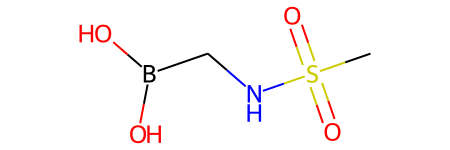

In [ ]:
core = Chem.MolFromSmiles("C12CCCC(C2)C1")
res, unmatched = rdRGD.RGroupDecompose([core],[inpmol])
mol_with_atom_index(refmol)
drawit(res[0]['R2'])
Chem.MolFromSmiles(Chem.MolToSmiles(res[0]['R2']).replace("[*:2]",'').replace("[*:1]",''))

In [ ]:
drawit(refmol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

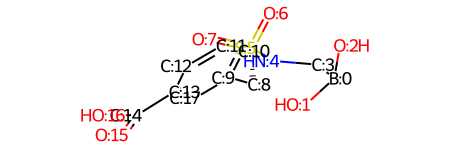

In [ ]:
mol_with_atom_index(refmol)

(8, 5, 6, 7, 4, 3, 0, 1, 2)
(8, 9, 10, 11, 12, 13, 14, 15, 16)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

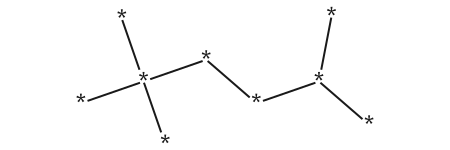

In [ ]:
mcs1 = rdFMCS.FindMCS([refmol, res[0]['R2']],timeout=5,bondCompare=rdFMCS.BondCompare.CompareAny)
mcs3 = rdFMCS.FindMCS([inpmol, res[0]['R2']],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
sidechain_ref = refmol.GetSubstructMatch(mcs1.queryMol)
sidechain_gen = inpmol.GetSubstructMatch(mcs3.queryMol)
print(sidechain_ref)
print(sidechain_gen)

atom_connect_sidechain_core_gen = get_connect_atom_in_core(inpmol, sidechain_gen)[0]

drawit(refmol)
drawit(res[0]['R2'])
mcs1.queryMol


In [ ]:
test_smi = Chem.MolToSmiles(res[0]['R2'])
side_chain_mol = Chem.MolFromSmiles(test_smi)
mcs2 = rdFMCS.FindMCS([refmol, side_chain_mol],timeout=5,ringCompare=Chem.rdFMCS.RingCompare.StrictRingFusion)
mcs2.queryMol
sidechain_ref = refmol.GetSubstructMatch(mcs2.queryMol)
sidechain_ref

(6, 5, 7, 8, 4, 3, 0, 1, 2)

In [ ]:
for R in ['R1','R2']:
    mcs1 = rdFMCS.FindMCS([refmol, res[0][R]],timeout=3,)
    mcs3 = rdFMCS.FindMCS([inpmol, res[0][R]],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
    sidechain_ref = refmol.GetSubstructMatch(mcs1.queryMol)
    sidechain_gen = inpmol.GetSubstructMatch(mcs3.queryMol)
    for i, j in zip(sidechain_ref,sidechain_gen):
        # print(f"{R} {i} {j}")
        ff_mcs.AddFixedPoint(j)
        conf_res.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))
    atom_connect_sidechain_core_ref = get_connect_atom_in_core(refmol, sidechain_ref)[0]
    atom_connect_sidechain_core_gen = get_connect_atom_in_core(inpmol, sidechain_gen)[0]
    print(atom_connect_sidechain_core_gen)
    ff_mcs.AddFixedPoint(atom_connect_sidechain_core_gen)
    conf_res.SetAtomPosition(atom_connect_sidechain_core_gen,bonded_conf.GetAtomPosition(atom_connect_sidechain_core_ref))

AttributeError: 'NoneType' object has no attribute 'AddFixedPoint'

In [ ]:
drawit(inpmol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
pdb = Chem.MolFromPDBBlock(lig_Block)
drawit(pdb)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
def phe2bch_with_smiles(smi):
    # 用于将给定配体中的*间位苯环骨架*替换为*螺旋桨烷骨架*的脚本
    # 用smi指定ligand的结构

    # 读入分子
    mol = Chem.MolFromSmiles(smi)
    # 识别间位取代部分: * 匹配任意原子；'!:' 非芳香键； *!:ccc(!:*)ccc 含间位取代的苯环
    patt = Chem.MolFromSmarts("*!:ccc(!:*)ccc")
    match = mol.GetSubstructMatches(patt)
    
    # 识别需要被替换苯环原子
    ri = mol.GetRingInfo()
    for r in ri.AtomRings():
        count = 0
        for item in match[0]:
            if item in set(r):
                count+=1
        if count == len(match[0])-2:
            phenyl_num = set(r)
    # 识别两个间位取代基与苯环的连接原子
    connect_atoms = list(set(match[0])-phenyl_num)
    # 记录第一部分的原子数目
    mol1_Atom_num = mol.GetNumAtoms()
    # 引入螺旋桨烷，并将其与原分子置于一处，使得其编号从·mol1_Atom_num+0·开始
    re_pat = Chem.MolFromSmiles("C12CCCC(C2)C1")
    mid_mol = Chem.CombineMols(mol,re_pat)
    # 开始成键
    mid_edited = Chem.EditableMol(mid_mol)
    # 螺旋桨烷烃的桥头碳分别为mol1_Atom_num和mol1_Atom_num+4
    mid_edited.AddBond(connect_atoms[0],mol1_Atom_num,order=Chem.rdchem.BondType.SINGLE)
    mid_edited.AddBond(connect_atoms[1],mol1_Atom_num+4,order=Chem.rdchem.BondType.SINGLE)
    # 删除原来的苯环
    # 每删除一个原子后原子序号都会发生改变，所以需要倒序删除。
    phenyl_atoms = list(phenyl_num)
    phenyl_atoms.sort(reverse=True)
    for i in phenyl_atoms:
        mid_edited.RemoveAtom(i)
    BCHep_mol = mid_edited.GetMol()
    return [BCHep_mol,mol1_Atom_num-6]  

test = phe2bch_with_smiles("Cc1c(sc(n1)N)c2ccnc(n2)Nc3cccc(c3)n4oo4")

In [ ]:
def getpdb(refmol,inpmol,pdbfile):
    mcs = rdFMCS.FindMCS([refmol, inpmol],timeout=3,bondCompare=rdFMCS.BondCompare.CompareOrderExact)
    bonded_conf = refmol.GetConformer()
    conf_res = inpmol.GetConformer()
    inpmol_prop = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(inpmol)
    ff_mcs = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(inpmol,inpmol_prop)
    for i, j in zip(refmol.GetSubstructMatch(mcs.queryMol), inpmol.GetSubstructMatch(mcs.queryMol)):
        ff_mcs.AddFixedPoint(j)
        conf_res.SetAtomPosition(j, bonded_conf.GetAtomPosition(i))
    Chem.MolToPDBFile(inpmol, pdbfile)
    return inpmol
